# Convolutional Neural Networks

## Project: Algorithm for a Dog Identification App 

---
The goal of the project is to create an algorithm that detects dogs' breed by the use of convolutional neural networks in PyTorch. At the end of this project, the code accepts any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling.

### The Road Ahead

The notebook is broken down into several steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Combine Algorithms
* [Step 6](#step6): Test

---
<a id='step0'></a>
## Step 0: Import Datasets

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the NumPy arrays `human_files` and `dog_files`.

In [12]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, the OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is used to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). The human face detector `haarcascade_frontalface_alt` is downloaded and stored in the `haarcascades` directory. In the next code cell, it is shown how to use this detector to find human faces in a sample image.

Number of faces detected: 1


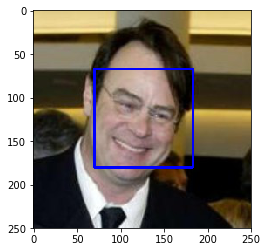

In [13]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter. So, before using any of the face detectors, it is necessary to convert the images to grayscale.  

In the above code, `faces` is a NumPy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

This procedure is used to define a function that returns `True` if a human face is detected in an image and `False` otherwise. The function name is `face_detector`. It takes a string-valued file path to an image as input and appears in the code block below.

In [10]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Test the algorithm on a dog and human images. Ideally, the algorithm detects 100% of human images with a detected face and 0% of dog images with a detected face. The algorithm is not perfect, but still gives an acceptable performance.  `human_files_short` and `dog_files_short` are file paths for the first 100 images from each of the datasets.

In [24]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

human_num = list(map(face_detector, human_files_short))
dog_num = list(map(face_detector, dog_files_short))
print(f"Percentage of human faces in:\n\t- human files:\t{sum(human_num)}%\n\t- dog flies:\t{sum(dog_num)}%")

Percentage of human faces in:
	- human files:	98%
	- dog flies:	17%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) is used to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [ ]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

`VGG16_predict` is a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model. The output should always be an integer between 0 and 999, inclusive.

In [33]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torchvision.transforms as T

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    transform = T.Compose([T.Resize(256),
                           T.CenterCrop(224),
                           T.ToTensor(),
                           T.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])])
    
    img = transform(Image.open(img_path))
    img = torch.unsqueeze(img, 0)
    
    if use_cuda:
        img = img.cuda()
    
    VGG16.eval()
    out = VGG16(img)
    _, class_pred = torch.max(out, dim=1)
    
    if use_cuda:
        class_pred = class_pred.cpu()
    
    return class_pred.item()

### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in a set of keys 151-268, inclusive and include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, to check if an VGG-16 model predicts a dog an output index must be between 151 and 268 (inclusive).

In [34]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    pred = VGG16_predict(img_path)
    return 151 <= pred <= 268

### Assess the Dog Detector

Test the performance of the dog_detector function on the images in human_files_short and dog_files_short.

In [19]:
human_num_2ap = list(map(dog_detector, human_files_short))
dog_num_2ap = list(map(dog_detector, dog_files_short))
print(f"Percentage of dogs in:\n\t- human files:\t{sum(human_num_2ap)}%\n\t- dog flies:\t{sum(dog_num_2ap)}%")

Percentage of dogs in:
	- human files:	0%
	- dog flies:	100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

In this section dogs' breed classifier is built using neural networks. It takes a dog image as input and outputs breed type. The  Convolution layers are used to create the neural network.

The task of assigning breed to dogs from images is considered exceptionally challenging. To see why - consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany.jpg" width="100"> | <img src="images/Welsh_springer_spaniel.jpg" width="200">

It is also worth to mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

### DataLoader

Below is the definition of PyTorch DataLoader. The images are preprocessed:
* cropped by 224x224 to have standardized inputs for Neural Network because there is a big variety of images' size in the dataset
* Normalized
* Image augmentation for better generalization
    * horizontal flip
    * rotation

In [16]:
import os
from torchvision import datasets

test_path = '/data/dog_images/test'
valid_path = '/data/dog_images/valid'
train_path = '/data/dog_images/train'

batch_size = 20
num_worker = 0

means_ = [0.485, 0.456, 0.406]
stds_ = [0.229, 0.224, 0.225]

transforms_valid = T.Compose([T.Resize(255),
                              T.CenterCrop(224),
                              T.ToTensor(),
                              T.Normalize(mean=means_, std=stds_)])

transforms_train = T.Compose([T.RandomHorizontalFlip(),
                              T.RandomRotation(15),
                              T.RandomResizedCrop(224),
                              T.ToTensor(),
                              T.Normalize(mean=means_, std=stds_)])

image_folder_test = datasets.ImageFolder(test_path, transform=transforms_valid)
image_folder_valid = datasets.ImageFolder(valid_path, transform=transforms_valid)
image_folder_train = datasets.ImageFolder(train_path, transform=transforms_train)

loader_test = torch.utils.data.DataLoader(image_folder_test, num_workers=num_worker, batch_size=batch_size, shuffle=False)
loader_valid = torch.utils.data.DataLoader(image_folder_valid, num_workers=num_worker, batch_size=batch_size, shuffle=False)
loader_train = torch.utils.data.DataLoader(image_folder_train, num_workers=num_worker, batch_size=batch_size, shuffle=True)

loaders_scratch = {'test': loader_test, 'valid': loader_valid, 'train': loader_train}

### CNN Model Architecture

The CNN architecture consists of four convolution layers combined with the max-pooling layer and the ReLu activation function. The output of the last convolution layer is flattened and combined with a couple of dropout and linear layers. Convolution layers double the depth of the tensor like 16 --> 32 --> 64 and each max-pooling layer shrinks the size of images by a factor of two. That's why finally we have a tensor of size 14x14x64 (apart from a batch size). Dropout layers help with model overfitting. The final layer has an output size of 133 which is what we need to make a classification.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.dropout = nn.Dropout(p=0.25)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(64*14*14, 784)
        self.linear2 = nn.Linear(784, 133)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64*14*14)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### Loss Function and Optimizer

There are several [loss functions](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizers](http://pytorch.org/docs/stable/optim.html) in the PyTorch documentation. In the current implementation CrossEntropyLoss and Adam are used.

In [18]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### Train and Validate the Model

In [23]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)

        train_loss /= len(loaders['train'].dataset)
        valid_loss /= len(loaders['valid'].dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss < valid_loss_min:
            print(f'Validation loss has decreased {valid_loss_min:.6f} -->  {valid_loss:.6f}. Saving model')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    return model

In [181]:
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.041224 	Validation Loss: 3.811963
Validation loss has decreased inf -->  3.811963. Saving model
Epoch: 2 	Training Loss: 3.995130 	Validation Loss: 3.834923
Epoch: 3 	Training Loss: 3.955519 	Validation Loss: 3.702666
Validation loss has decreased 3.811963 -->  3.702666. Saving model
Epoch: 4 	Training Loss: 3.893807 	Validation Loss: 3.710518
Epoch: 5 	Training Loss: 3.851273 	Validation Loss: 3.641411
Validation loss has decreased 3.702666 -->  3.641411. Saving model
Epoch: 6 	Training Loss: 3.826944 	Validation Loss: 3.679325
Epoch: 7 	Training Loss: 3.786228 	Validation Loss: 3.625584
Validation loss has decreased 3.641411 -->  3.625584. Saving model
Epoch: 8 	Training Loss: 3.761702 	Validation Loss: 3.595928
Validation loss has decreased 3.625584 -->  3.595928. Saving model
Epoch: 9 	Training Loss: 3.725069 	Validation Loss: 3.550884
Validation loss has decreased 3.595928 -->  3.550884. Saving model
Epoch: 10 	Training Loss: 3.698203 	Validation Loss: 3

In [24]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model

Try out trained model on the test dataset of dog images.

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [27]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.866959


Test Accuracy: 31% (260/836)


---
<a id='step4'></a>
## Step 4: CNN to Classify Dog Breeds (using Transfer Learning)

The accuracy of the CNN model from step 3 is quite low. What if we use a more complex pre-trained model for transfer learning to create a CNN that can identify dog breed from images. 

In [21]:
import os
from torchvision import datasets

test_path = '/data/dog_images/test'
valid_path = '/data/dog_images/valid'
train_path = '/data/dog_images/train'

batch_size = 40
num_worker = 0

means_ = [0.485, 0.456, 0.406]
stds_ = [0.229, 0.224, 0.225]

transforms_valid = T.Compose([T.Resize(255),
                              T.CenterCrop(224),
                              T.ToTensor(),
                              T.Normalize(mean=means_, std=stds_)])

transforms_train = T.Compose([T.RandomHorizontalFlip(),
                              T.RandomRotation(15),
                              T.RandomResizedCrop(224),
                              T.ToTensor(),
                              T.Normalize(mean=means_, std=stds_)])

image_folder_test = datasets.ImageFolder(test_path, transform=transforms_valid)
image_folder_valid = datasets.ImageFolder(valid_path, transform=transforms_valid)
image_folder_train = datasets.ImageFolder(train_path, transform=transforms_train)

loader_test = torch.utils.data.DataLoader(image_folder_test, num_workers=num_worker, batch_size=batch_size, shuffle=False)
loader_valid = torch.utils.data.DataLoader(image_folder_valid, num_workers=num_worker, batch_size=batch_size, shuffle=False)
loader_train = torch.utils.data.DataLoader(image_folder_train, num_workers=num_worker, batch_size=batch_size, shuffle=True)

loaders_transfer = {'test': loader_test, 'valid': loader_valid, 'train': loader_train}

### Model Architecture

For transfer learning, several pre-trained models are tested to find a balance between complexity and accuracy. On each of all layers apart from the last one (classification layer) are frozen. First, VGG16 with batch normalization is tested. It is simple enough (does not have too many layers to learn) yet it is quite powerful (top 1 and 5 errors are 26.63 and 8.50 respectively on ImageNet). In addition, I adopted the last linear layer to have 133 outputs. But the model has not shown accuracy higher than 60%. But ResNet50 on the third epoch has shown accuracy 81%. And after 10 epochs the accuracy reached 87%.

In [ ]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet50(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()

###  Loss Function and Optimizer

In [23]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### Train and Validate the Model

In [46]:
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.036491 	Validation Loss: 0.529781
Validation loss has decreased inf -->  0.529781. Saving model
Epoch: 2 	Training Loss: 0.930597 	Validation Loss: 0.539615
Epoch: 3 	Training Loss: 0.917194 	Validation Loss: 0.517119
Validation loss has decreased 0.529781 -->  0.517119. Saving model
Epoch: 4 	Training Loss: 0.821457 	Validation Loss: 0.546815
Epoch: 5 	Training Loss: 0.808627 	Validation Loss: 0.446373
Validation loss has decreased 0.517119 -->  0.446373. Saving model
Epoch: 6 	Training Loss: 0.790458 	Validation Loss: 0.440623
Validation loss has decreased 0.446373 -->  0.440623. Saving model
Epoch: 7 	Training Loss: 0.764950 	Validation Loss: 0.449977
Epoch: 8 	Training Loss: 0.745166 	Validation Loss: 0.517112
Epoch: 9 	Training Loss: 0.746413 	Validation Loss: 0.473000
Epoch: 10 	Training Loss: 0.716990 	Validation Loss: 0.413676
Validation loss has decreased 0.440623 -->  0.413676. Saving model


In [24]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### Test the Model

In [51]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.452068


Test Accuracy: 87% (734/836)


### Predict Dog Breed with the Model

A function `predict_breed_transfer` takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [42]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    transform = T.Compose([T.Resize(255),
                           T.CenterCrop(224),
                           T.ToTensor(),
                           T.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])])  
    
    img = transform(Image.open(img_path))
    img = torch.unsqueeze(img, 0)
    
    if use_cuda:
        img = img.cuda()
    
    model_transfer.eval()
    out = model_transfer(img)
    _, class_pred = torch.max(out, dim=1)
    
    if use_cuda:
        class_pred = class_pred.cpu()
    
    return class_names[class_pred.item()]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

An algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide an output that indicates an error.

In [48]:
def run_app(img_path):
    if dog_detector(img_path):
        return predict_breed_transfer(img_path)
    elif face_detector(img_path):
        return "human looks lile " + predict_breed_transfer(img_path)
    else:
        return "eror"

---
<a id='step6'></a>
## Step 6: Improvements and Test The Algorithm on Sample Images

### Further improvements:

1. To use neural network for face detection instead of CV2 function `face_cascade.detectMultiScale()`.
2. To add more data augmentation like sharpness, brightness, etc.
3. To add data without dogs and humans and create a neural network that separates into three categories humans, dogs and others.
4. To use more advanced pre-trained NN instead of VGG16 and ResNet-50.
5. Unfreeze not only the last layer on NN but all of them or the last few.

### Test:

In [73]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    print(run_app(file))

human
human
human
Mastiff
Mastiff
Cane corso


In [44]:
from PIL import Image
import requests
from io import BytesIO

def show_prediction(url_):
    response = requests.get(url_)
    img = Image.open(BytesIO(response.content))
    img_name = str(index_) + "_test.jpg"
    img.save(img_name)
    plt.imshow(img);
    plt.title(run_app(img_name))
    plt.show()
    os.remove(img_name)

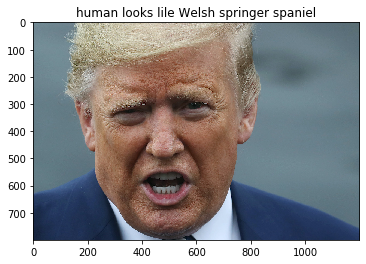

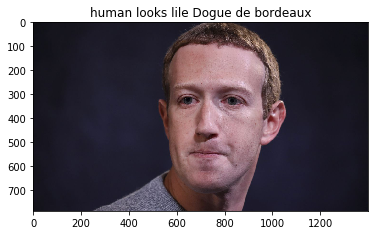

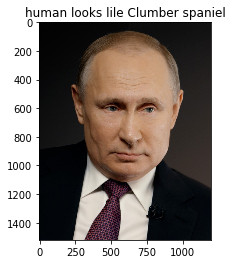

In [49]:
humans = ['https://www.themarysue.com/wp-content/uploads/2020/03/trump-coronavirus-face-touch.jpg',
          'https://cdn.vox-cdn.com/thumbor/0ux4sSffztqSOFPLoU2IsuPt1b4=/1400x788/filters:format(jpeg)/cdn.vox-cdn.com/uploads/chorus_asset/file/19407568/1178141765.jpg.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Vladimir_Putin_%282020-02-20%29.jpg/1200px-Vladimir_Putin_%282020-02-20%29.jpg']

for index_, url_ in enumerate(humans):
    show_prediction(url_)

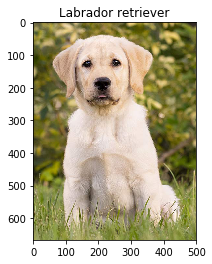

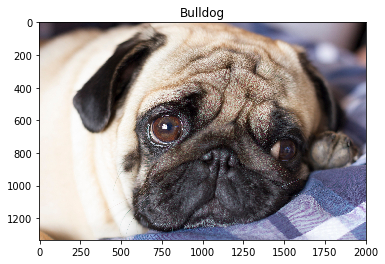

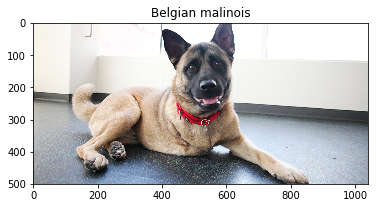

In [110]:
dogs = ['https://www.guidedogs.org/wp-content/uploads/2019/11/website-donate-mobile.jpg',
        'https://cdn.mos.cms.futurecdn.net/JzqhuEDTRfCZKMKHUxPySB.jpg',
        'https://www.aspca.org/sites/default/files/blog_make-dogs-day_101619_main.jpg']

for index_, url_ in enumerate(dogs):
    show_prediction(url_)

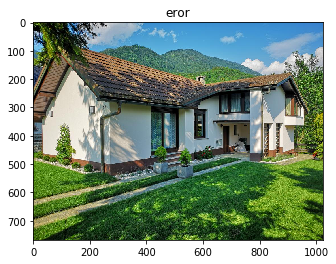

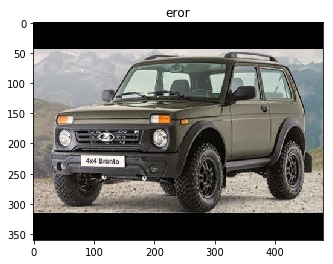

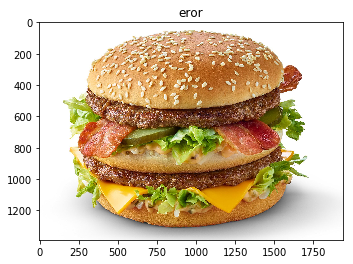

In [111]:
random_photos = ['https://q-cf.bstatic.com/images/hotel/max1024x768/208/208187160.jpg',
                 'https://images.autouncle.com/at/car_images/389c4927-170b-4801-99d5-2cde64de6aaa_lada-taiga-bronto-lkw.jpg',
                 'https://www.thesun.co.uk/wp-content/uploads/2020/01/23_Kiosk_GrandMacBacon_MR-e1580136599445.jpg']

for index_, url_ in enumerate(random_photos):
    show_prediction(url_)